# Start with this template for a simple C program to create an HDF5 file:
    // These are the function calls you will need.

    hid_t H5Fcreate( const char *name, unsigned flags, hid_t fcpl_id, hid_t fapl_id )
    hid_t H5Screate_simple( int rank, const hsize_t * current_dims, const hsize_t * maximum_dims )    
    hid_t H5Gcreate( hid_t loc_id, const char *name, hid_t lcpl_id, hid_t gcpl_id, hid_t gapl_id )
    hid_t H5Dcreate( hid_t loc_id, const char *name, hid_t dtype_id, hid_t space_id, hid_t lcpl_id, hid_t dcpl_id, hid_t dapl_id )
    herr_t H5Dwrite( hid_t dataset_id, hid_t mem_type_id, hid_t mem_space_id, hid_t file_space_id, hid_t xfer_plist_id, const void * buf )

    herr_t H5Xclose(Xid);

## Fill out the template, then compile and run:

    #include <hdf5.h>
    #include <assert.h>

    int main(int argc, char *argv[]){

        // create the file
        hid_t file_id = H5Fcreate( "my_file.h5", H5F_ACC_TRUNC, H5P_DEFAULT, H5P_DEFAULT );    
        // create the group
        hid_t group_id = H5Gcreate( file_id, "my_group", H5P_DEFAULT, H5P_DEFAULT, H5P_DEFAULT );

        // create a dataspace and dataset
        int rank = 2;
        const hsize_t dims[] = {4,6};
        hid_t space_id = H5Screate_simple( rank, dims, dims );
        hid_t dataset_id = H5Dcreate( group_id, "my_dset_name", H5T_NATIVE_INT, space_id, H5P_DEFAULT, 
                                      H5P_DEFAULT, H5P_DEFAULT );

        // create some data to write
        int buf[dims[0]][dims[1]];
        int i,j;
        for (i=0; i<dims[0]; i++) for (j=0; j<dims[1]; j++) buf[i][j] = i * dims[1] + j + 1;

        // write the data
        herr_t status = H5Dwrite( dataset_id, H5T_NATIVE_INT, H5S_ALL, H5S_ALL, H5P_DEFAULT,  buf );
        assert (status >= 0);

        // close all the resources
        assert( H5Dclose(dataset_id) >= 0);
        assert( H5Sclose(space_id) >= 0);
        assert( H5Gclose(group_id) >= 0);
        assert( H5Fclose(file_id) >= 0);

        return 0;
    }


## Compile and run the example. Generate "my_file.h5"

    $ h5cc create.c 
    $ ./a.out  
    $ h5dump my_file.h5 
    HDF5 "my_file.h5" {
    GROUP "/" {
       DATASET "my_dset" {
          DATATYPE  H5T_IEEE_F32LE
          DATASPACE  SIMPLE { ( 3, 4 ) / ( 3, 4 ) }
          DATA {
          (0,0): 0, 0, 0, 0,
          (1,0): 0, 0, 0, 0,
          (2,0): 0, 0, 0, 0
          }
       }
    }
    }

---

# Use python to operate on same file

Now, launch a jupyter notebook to open and modify the file:
    $ jupyter notebook

Check to see what IP# your notebook is binding to
    $ ifconfig 
Attach to the notebook at e.g.:

http://192.168.56.102:8888/ 


In [7]:
import h5py

In [8]:
filename = "my_file.h5"
file = h5py.File(filename, "a")

In [9]:
file

<HDF5 file "my_file.h5" (mode r+)>

In [10]:
data = [1,2,3,4]

In [11]:
file.create_dataset(name="new_dset", data=data)

<HDF5 dataset "new_dset": shape (4,), type "<i8">

In [12]:
dataset_in_file = file["new_dset"]

In [13]:
dataset_in_file[:]

array([1, 2, 3, 4])

In [14]:
dataset_in_file[2] = 555

In [15]:
file["new_dset"][:]

array([  1,   2, 555,   4])

In [16]:
!h5dump my_file.h5

HDF5 "my_file.h5" {
GROUP "/" {
   GROUP "my_group" {
      DATASET "my_dataset" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 3, 4 ) / ( 3, 4 ) }
         DATA {
         (0,0): 0, 0, 0, 0,
         (1,0): 0, 0, 0, 0,
         (2,0): 0, 0, 0, 0
         }
      }
   }
}
}


In [17]:
file.flush()

In [18]:
!h5dump my_file.h5

HDF5 "my_file.h5" {
GROUP "/" {
   GROUP "my_group" {
      DATASET "my_dataset" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 3, 4 ) / ( 3, 4 ) }
         DATA {
         (0,0): 0, 0, 0, 0,
         (1,0): 0, 0, 0, 0,
         (2,0): 0, 0, 0, 0
         }
      }
   }
   DATASET "new_dset" {
      DATATYPE  H5T_STD_I64LE
      DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
      DATA {
      (0): 1, 2, 555, 4
      }
   }
}
}


In [19]:
del file["new_dset"]

In [20]:
file.flush()

In [21]:
!h5dump my_file.h5

HDF5 "my_file.h5" {
GROUP "/" {
   GROUP "my_group" {
      DATASET "my_dataset" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 3, 4 ) / ( 3, 4 ) }
         DATA {
         (0,0): 0, 0, 0, 0,
         (1,0): 0, 0, 0, 0,
         (2,0): 0, 0, 0, 0
         }
      }
   }
}
}


In [22]:
file.close()

# Load a remote dataset *via* RESTful API

In [23]:
%matplotlib inline

In [24]:
import h5pyd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [25]:
domain = "tasmax_day_BCSD_rcp45_r1i1p1_CanESM2_2050.nasa.data.hdfgroup.org"
endpoint = "https://data.hdfgroup.org:7258"

In [26]:
remote_file = h5pyd.File(domain, 'r', endpoint=endpoint)

In [27]:
remote_file

<HDF5 file "tasmax_day_BCSD_rcp45_r1i1p1_CanESM2_2050.nasa.data.hdfgroup.org" (mode r)>

In [28]:
remote_dset = remote_file["/tasmax"]

In [29]:
remote_dset.shape

(365, 720, 1440)

In [30]:
remote_dset.dtype

dtype('float32')

In [31]:
remote_slice=remote_dset[0,:,:]
remote_slice=np.squeeze(remote_slice)

In [32]:
remote_slice.shape

(720, 1440)

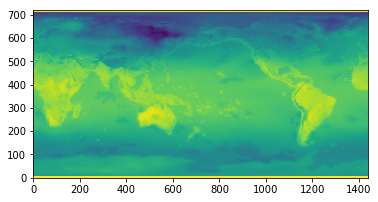

In [33]:
plt.imshow(np.clip(remote_slice, 200, 320), origin='lower')

## Save the remote slice locally

We can grab the dataset from the remote file and do anything H5 with it, including inserting it into our local file:

In [34]:
filename = "my_file.h5"
file = h5py.File(filename, "a")
file

<HDF5 file "my_file.h5" (mode r+)>

In [35]:
remote_slice = remote_slice[:60, :60]
remote_slice.shape

(60, 60)

In [36]:
dataset_in_file = file.create_dataset(name="remote_dset", data=remote_slice) 

In [37]:
file.flush()

In [38]:
!h5dump my_file.h5

HDF5 "my_file.h5" {
GROUP "/" {
   GROUP "my_group" {
      DATASET "my_dataset" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 3, 4 ) / ( 3, 4 ) }
         DATA {
         (0,0): 0, 0, 0, 0,
         (1,0): 0, 0, 0, 0,
         (2,0): 0, 0, 0, 0
         }
      }
   }
   DATASET "remote_dset" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 60, 60 ) / ( 60, 60 ) }
      DATA {
      (0,0): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (0,9): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (0,18): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (0,27): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (0,36): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (0,45): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (0,54): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20,
      (1,0): 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e+20, 1e

In [39]:
file.close()

In [40]:
file

<Closed HDF5 file>